In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [2]:
df = pd.read_csv('PLTR.csv',index_col=0,parse_dates=True)

In [3]:
df.dropna(inplace=True)
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-09-30,10.00,11.41,9.11,9.50,9.50,338584400
2020-10-01,9.69,10.10,9.23,9.46,9.46,124297600
2020-10-02,9.06,9.28,8.94,9.20,9.20,55018300
2020-10-05,9.43,9.49,8.92,9.03,9.03,36316900
2020-10-06,9.04,10.18,8.90,9.90,9.90,90864000


In [4]:
df_new = df.drop(columns=['Open','High','Low','Adj Close','Volume'])
df_new.tail()

,Close
Date,
2021-02-12,31.91
2021-02-16,27.84
2021-02-17,27.08
2021-02-18,25.17
2021-02-19,29.00


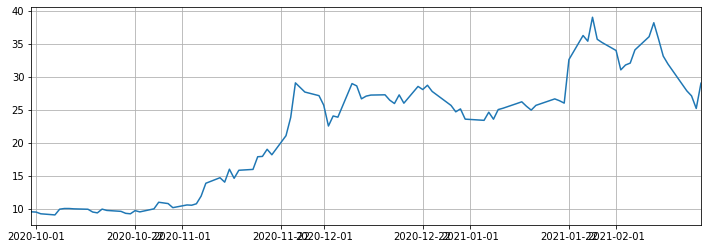

In [5]:
plt.figure(figsize=(12,4))
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(df_new)

In [6]:
y = df['Close'].values.astype(float)


test_size = 14

train_set = y[:-test_size]
test_set = y[-test_size:]

In [7]:
test_set

array([33.959999, 31.02    , 31.76    , 32.049999, 34.049999, 36.049999,
       38.169998, 35.700001, 33.110001, 31.91    , 27.84    , 27.08    ,
       25.17    , 29.      ])

In [8]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))

In [9]:
train_norm = scaler.fit_transform(train_set.reshape(-1, 1))

In [10]:
# Convert train_norm from an array to a tensor
train_norm = torch.FloatTensor(train_norm).view(-1)

# Define a window size
window_size = 12

# Define function to create seq/label tuples
def input_data(seq,ws):  # ws is the window size
    out = []
    L = len(seq)
    for i in range(L-ws):
        window = seq[i:i+ws]
        label = seq[i+ws:i+ws+1]
        out.append((window,label))
    return out

# Apply the input_data function to train_norm
train_data = input_data(train_norm,window_size)
len(train_data)  

72

In [11]:
train_data[0]

(tensor([-0.9686, -0.9713, -0.9887, -1.0000, -0.9419, -0.9353, -0.9353, -0.9386,
         -0.9426, -0.9706, -0.9793, -0.9413]),
 tensor([-0.9546]))

In [12]:
class LSTMnetwork(nn.Module):
    def __init__(self,input_size=1,hidden_size=100,output_size=1):
        super().__init__()
        self.hidden_size = hidden_size
        
        # Add an LSTM layer:
        self.lstm = nn.LSTM(input_size,hidden_size)
        
        # Add a fully-connected layer:
        self.linear = nn.Linear(hidden_size,output_size)
        
        # Initialize h0 and c0:
        self.hidden = (torch.zeros(1,1,self.hidden_size),
                       torch.zeros(1,1,self.hidden_size))

    def forward(self,seq):
        lstm_out, self.hidden = self.lstm(
            seq.view(len(seq),1,-1), self.hidden)
        pred = self.linear(lstm_out.view(len(seq),-1))
        return pred[-1]  # last value

In [13]:
torch.manual_seed(101)
model = LSTMnetwork()

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

model

LSTMnetwork(
  (lstm): LSTM(1, 100)
  (linear): Linear(in_features=100, out_features=1, bias=True)
)

In [14]:
epochs = 10

import time
start_time = time.time()

for epoch in range(epochs):
    
    # extract the sequence & label from the training data
    for seq, y_train in train_data:
        
        # reset the parameters and hidden states
        optimizer.zero_grad()
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))
        
        y_pred = model(seq)
        
        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()
        
    # print training result
    print(f'Epoch: {epoch+1:2} Loss: {loss.item():10.8f}')
    
print(f'\nDuration: {time.time() - start_time:.0f} seconds')

Epoch:  1 Loss: 0.24943663
Epoch:  2 Loss: 0.10808866
Epoch:  3 Loss: 0.12777404
Epoch:  4 Loss: 0.02741243
Epoch:  5 Loss: 0.01504429
Epoch:  6 Loss: 0.00271314
Epoch:  7 Loss: 0.00039824
Epoch:  8 Loss: 0.00000025
Epoch:  9 Loss: 0.00004589
Epoch: 10 Loss: 0.00005083

Duration: 2 seconds


In [15]:
future = 7

# Add the last window of training values to the list of predictions
preds = train_norm[-window_size:].tolist()

# Set the model to evaluation mode
model.eval()

for i in range(future):
    seq = torch.FloatTensor(preds[-window_size:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))
        preds.append(model(seq).item())

In [16]:
true_predictions = scaler.inverse_transform(np.array(preds[window_size:]).reshape(-1, 1))
true_predictions

array([[34.60110569],
       [33.70645725],
       [32.90835393],
       [32.23408674],
       [31.67065639],
       [31.19474161],
       [30.78611065]])

In [17]:
epochs = 200

# set model to back to training mode
model.train()

# feature scale the entire dataset
y_norm = scaler.fit_transform(y.reshape(-1, 1))
y_norm = torch.FloatTensor(y_norm).view(-1)
all_data = input_data(y_norm,window_size)

import time
start_time = time.time()

for epoch in range(epochs):
    
    # train on the full set of sequences
    for seq, y_train in all_data:  
        
        # reset the parameters and hidden states
        optimizer.zero_grad()
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))
        
        y_pred = model(seq)
        
        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()
        
    # print training result
    print(f'Epoch: {epoch+1:2} Loss: {loss.item():10.8f}')
    
print(f'\nDuration: {time.time() - start_time:.0f} seconds')

Epoch:  1 Loss: 0.02524299
Epoch:  2 Loss: 0.02175316
Epoch:  3 Loss: 0.02070570
Epoch:  4 Loss: 0.01757898
Epoch:  5 Loss: 0.01606130
Epoch:  6 Loss: 0.01538522
Epoch:  7 Loss: 0.01392444
Epoch:  8 Loss: 0.01216037
Epoch:  9 Loss: 0.01023623
Epoch: 10 Loss: 0.00840310
Epoch: 11 Loss: 0.00684561
Epoch: 12 Loss: 0.00569265
Epoch: 13 Loss: 0.00497282
Epoch: 14 Loss: 0.00464258
Epoch: 15 Loss: 0.00463270
Epoch: 16 Loss: 0.00488591
Epoch: 17 Loss: 0.00529919
Epoch: 18 Loss: 0.00572032
Epoch: 19 Loss: 0.00616233
Epoch: 20 Loss: 0.00671509
Epoch: 21 Loss: 0.00741104
Epoch: 22 Loss: 0.00818513
Epoch: 23 Loss: 0.00840160
Epoch: 24 Loss: 0.00839249
Epoch: 25 Loss: 0.00696355
Epoch: 26 Loss: 0.00729650
Epoch: 27 Loss: 0.00363387
Epoch: 28 Loss: 0.00954422
Epoch: 29 Loss: 0.00035971
Epoch: 30 Loss: 0.04539213
Epoch: 31 Loss: 0.02182221
Epoch: 32 Loss: 0.02804021
Epoch: 33 Loss: 0.02458072
Epoch: 34 Loss: 0.01504416
Epoch: 35 Loss: 0.00806482
Epoch: 36 Loss: 0.00414492
Epoch: 37 Loss: 0.00382141
E

In [18]:
window_size = 14
future = 4
L = len(y)

preds = y_norm[-window_size:].tolist()

model.eval()
for i in range(future):  
    seq = torch.FloatTensor(preds[-window_size:])
    with torch.no_grad():
        # Reset the hidden parameters here!
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))  
        preds.append(model(seq).item())

# Inverse-normalize the prediction set
true_predictions = scaler.inverse_transform(np.array(preds).reshape(-1, 1))

In [19]:
true_predictions[-future:]

array([[31.82818755],
       [35.02055346],
       [34.95140023],
       [31.70272139]])